In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

c:\Users\matim\AppData\Local\Programs\Python\Python311\Lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [3]:
def lowering_a(N):
    ''' Creates the lowering operator for a N-level system '''
    return np.diag(np.sqrt(np.arange(1, N)), 1)
def raising_a(N):
    ''' Creates the raising operator for a N-level system'''
    return np.diag(np.sqrt(np.arange(1, N)), -1)

def System(N, wc, wa, g, alpha):
    ''' Creates the Hamiltonian and the initial state of the system'''
    destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator

    num_atm = destruction.T @ destruction # atomic number operator
    num_cav = np.kron(np.eye(2), lowering_a(N).T @ lowering_a(N)) #cavity number operator


    a_dag_X_destruction = np.kron(np.eye(2), lowering_a(N)).T @ destruction # raising times destruction operators
    a_X_creation = np.kron(np.eye(2), lowering_a(N)) @ destruction.T # lowering times creation operators

    H = wc * num_cav + wa * num_atm + g * (a_dag_X_destruction+ a_X_creation) # Hamiltonian

    psi_cav = coherent(N, alpha) # initial state of the cavity

    psi_atm = np.array([[0],[1]])   # initial state of the atom

    psi0 = np.kron(psi_atm, psi_cav) # initial state of the system
    return H, psi0



## Single atom master equation 

$
\frac{d\rho}{dt} = -i [H, \rho] +  \left( \sigma \rho \sigma^\dagger - \frac{1}{2} \{\sigma^\dagger \sigma, \rho\} \right)
$

In [7]:
def liouvillian(H, c_ops, gamma):
    """ Returns the Liouvillian superoperator of the system"""
    d = len(H)
    
    super_H = -1j * (np.kron(np.eye(d), H) - np.kron(H.T, np.eye(d))) # Hamiltonian superoperator
    super_c_ops = gamma * (np.kron(c_ops.conj(), c_ops) - 0.5 *\
                            (np.kron(np.eye(d), c_ops.conj().T @ c_ops) +\
                            np.kron((c_ops.T @ c_ops.conj()), np.eye(d)))) # collapse superoperator
    return super_H + super_c_ops

### Time evolution using exponential of Liouvillian superoperator

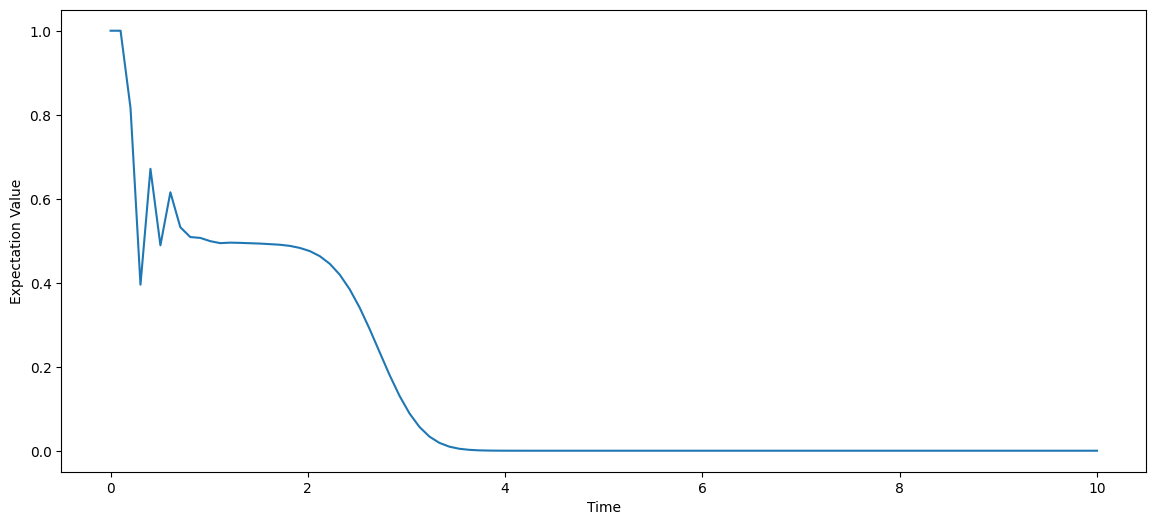

In [31]:
from scipy.linalg import expm
N = 20 # Number of photon states in the cavity
wc = 1 # Cavity frequency
wa = 1 # Atom frequency
g = 1   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

sigma = np.kron(lowering_a(2), np.eye(N))
sigma_dag = sigma.conj().T

num_at = sigma_dag @ sigma


H, psi0 = System(N, wc, wa, g, alpha)
rho = np.outer(psi0, psi0.conj())

times = np.linspace(0, 10, 100)

n_expect = np.zeros(len(times))

L = liouvillian(H, sigma, 1)

for i, t in enumerate(times):
    
    n_expect[i] = np.trace(np.real(rho @ (num_at)))    # calculate the expectation value of the number operator
    
    U = expm(L * t)                                    # evolution operator
    
    rho_vec = np.reshape(rho, (len(rho)**2, 1))        # vectorize the density matrix
    rho_vec_t = U @ rho_vec                            # apply the evolution operator
    rho = np.reshape(rho_vec_t, (len(rho), len(rho)))  # reshape the density matrix
    
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Expectation Value')
#plt.title('Collapse and Revival Plot')
plt.show()



### TIme evolution using the Runde-Kutta method

In [4]:
def liouvillian_step(y, t, H, c_ops,  gamma):
    """ Perform a single step of the Liouvillian evolution."""
    step = -1j * (H @ y - y @ H) + gamma * (c_ops @ y @ c_ops.conj().T\
        - 0.5 * (c_ops.conj().T @ c_ops @ y + y @ c_ops.conj().T @ c_ops))
    return step

def rk4_step(f, y, t, dt):
    """Perform a single Runge-Kutta step."""
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3, t + dt)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

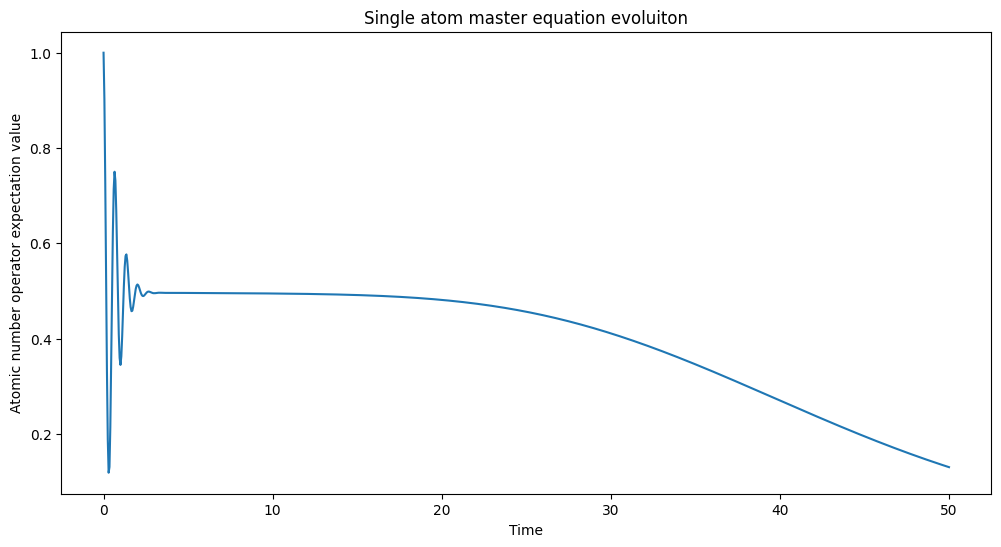

In [19]:
N = 40 # Number of photon states in the cavity
wc = 1 # Cavity frequency
wa = 1 # Atom frequency
g = 1   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

sigma = np.kron(lowering_a(2), np.eye(N))
sigma_dag = sigma.conj().T

num_at = sigma_dag @ sigma


H, psi0 = System(N, wc, wa, g, alpha)
rho = np.outer(psi0, psi0.conj())

times, dt = np.linspace(0, 50, 1000, retstep=True)

n_expect = np.zeros(len(times))

for i, t in enumerate(times):
    
    n_expect[i] = np.trace(np.real(rho @ (num_at)))
    
    rho = rk4_step(lambda rho, t: liouvillian_step(rho, t, H, sigma, 1), rho, t, dt)
    
plt.figure(figsize=(12, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Atomic number operator expectation value')
plt.title('Single atom master equation evoluiton')
plt.show()

## Master equation with a sum over atoms

$
\frac{d\rho}{dt} = -i [H, \rho] + \sum_k \left( \sigma_{k} \rho \sigma_{k}^\dagger - \frac{1}{2} \{\sigma_{k}^\dagger \sigma_{k}, \rho\} \right)
$

In [5]:
def liou_step_many_atoms(y, t, H, c_ops, gamma):
    """ Perform a single step of the Liouvillian evolution."""
    d = int(len(H)/2)
    L1 = np.kron(c_ops(2), np.eye(d))
    L2 = np.kron(np.eye(2), c_ops(d))
    
    L_ops = [L1, L2]
    
    step = -1j * (H @ y - y @ H) + gamma *\
        np.sum([L @ y @ L.conj().T - 0.5 * (L.conj().T @ L @ y + y @ L.conj().T @ L) for L in L_ops], axis=0)
        
    return step

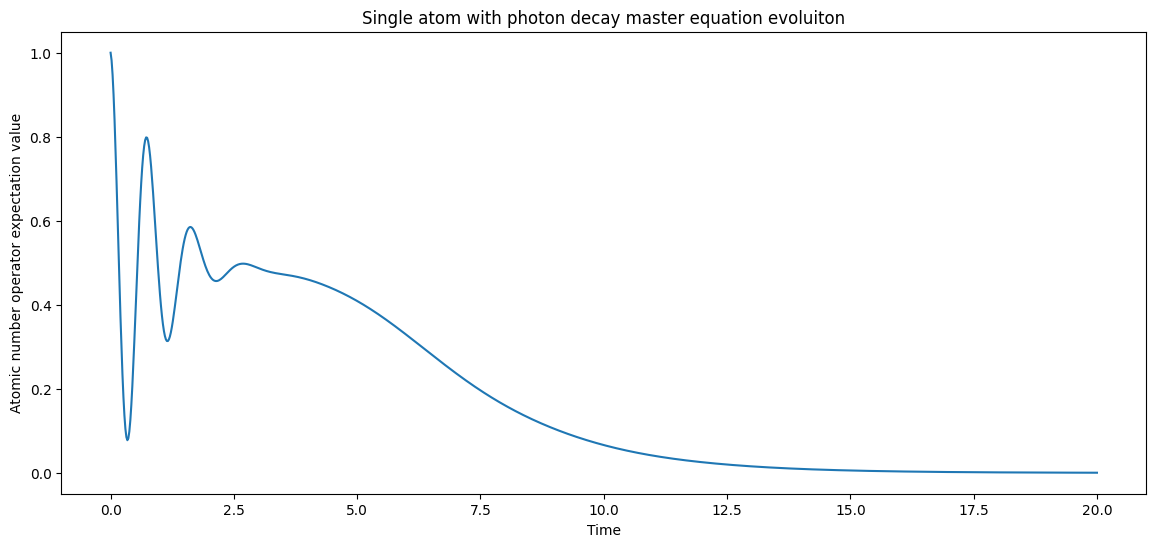

In [18]:
N = 40 # Number of photon states in the cavity
wc = 1 # Cavity frequency
wa = 1 # Atom frequency
g = 1   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

sigma = np.kron(lowering_a(2), np.eye(N))
sigma_dag = sigma.conj().T

num_at = sigma_dag @ sigma


H, psi0 = System(N, wc, wa, g, alpha)
rho = np.outer(psi0, psi0.conj())

times, dt = np.linspace(0, 20, 1000, retstep=True)

n_expect = np.zeros(len(times))

for i, t in enumerate(times):
    
    n_expect[i] = np.trace(np.real(rho @ (num_at)))
    
    rho = rk4_step(lambda rho, t: liou_step_many_atoms(rho, t, H, lowering_a, 0.5), rho, t, dt)
    
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Atomic number operator expectation value')
plt.title('Single atom with photon decay master equation evoluiton')
plt.show()